In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### generation analysis

In [62]:
def load_generation_data(exclude_files=None):
    # data/generation 디렉토리 경로
    data_dir = '/Users/jangseohyun/Documents/workspace/symply/DER/data/generation'
    
    # 디렉토리 내의 모든 CSV 파일 목록 가져오기
    all_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.csv')])
    
    # 제외할 파일 처리
    if exclude_files is not None:
        files_to_load = [f for f in all_files if f not in exclude_files]
    else:
        files_to_load = all_files
    
    # 선택된 파일들 불러오기
    data_frames = {}
    loaded_files = []
    for file in files_to_load:
        file_path = os.path.join(data_dir, file)
        df = pd.read_csv(file_path)
        data_frames[file] = df
        loaded_files.append(file)
    print(f"총 {len(loaded_files)}개를 불러왔습니다 ({', '.join(loaded_files)})")
    
    return data_frames

In [63]:
def plot_daily_generation(data_frames, selected_dates=None):
    # 첫 번째 데이터를 기준으로 날짜 목록 가져오기
    first_df = list(data_frames.values())[0]
    dates_array = np.array(first_df['Date'].unique())
    
    # selected_dates 처리
    if selected_dates is None:
        # None이면 모든 날짜 사용
        dates_to_plot = dates_array
    elif isinstance(selected_dates, (int, np.integer)):
        # 숫자 하나만 입력한 경우
        dates_to_plot = [dates_array[selected_dates]]
    elif isinstance(selected_dates, list):
        # 날짜 리스트를 입력한 경우
        dates_to_plot = [dates_array[i] for i in selected_dates]
    else:
        raise ValueError("selected_dates must be None, int, or list of ints")
    
    n_colors = len(data_frames)
    cmap = plt.cm.get_cmap('tab20', n_colors)  # 'tab20'에서 n_colors 개수만큼 추출
    colors = [cmap(i) for i in range(n_colors)]  # 색상을 리스트로 저장

    
    # 각 선택된 날짜별로 플랏
    for date in dates_to_plot:
        plt.figure(figsize=(15, 9))
        
        # 최대 발전량 값을 저장할 변수
        max_generation = 0
        
        # 각 발전기(CSV 파일)별로 플랏
        for idx, (file_name, df) in enumerate(data_frames.items()):
            mask = df['Date'] == date
            daily_hours = df[mask]['Hour (Eastern Time, Daylight-Adjusted)'].to_numpy()
            daily_generation = pd.to_numeric(df[mask]['Electricity Generated'], errors='coerce').to_numpy()
            
            if len(daily_generation) > 0:
                max_generation = max(max_generation, np.nanmax(daily_generation))
            
            label = f'DER {file_name.split(".")[0]}'
            plt.plot(daily_hours, daily_generation, label=label, 
                    color=colors[idx], marker='o')
        
        # y축 눈금 설정 - 최대값을 500 단위로 올림하고 여유 공간 추가
        y_max = np.ceil(max_generation / 500) * 10 # 500 단위로 올림
        y_max = y_max + 450  # 위쪽에 여유 공간 추가
        y_ticks = np.linspace(0, y_max, 5)  # 10개의 균등한 간격
        plt.ylim(0, y_max)  # y축 범위 설정
        plt.yticks(y_ticks)
        
        plt.title(f'Daily Generation - {date}')
        plt.xlabel('Hour')
        plt.ylabel('Electricity Generated (kW)')
        plt.legend(loc='upper left', fontsize = 13)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.xticks(range(0, 24))
        plt.tight_layout()
        plt.show()

In [64]:
# data = load_generation_data()
# plot_daily_generation(data, 18)

총 10개를 불러왔습니다 (1201.csv, 137.csv, 281.csv, 397.csv, 401.csv, 430.csv, 514.csv, 524.csv, 775.csv, 89.csv)


C:\Users\jangseohyun\AppData\Local\Temp\ipykernel_17808\1501771418.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', n_colors)  # 'tab20'에서 n_colors 개수만큼 추출


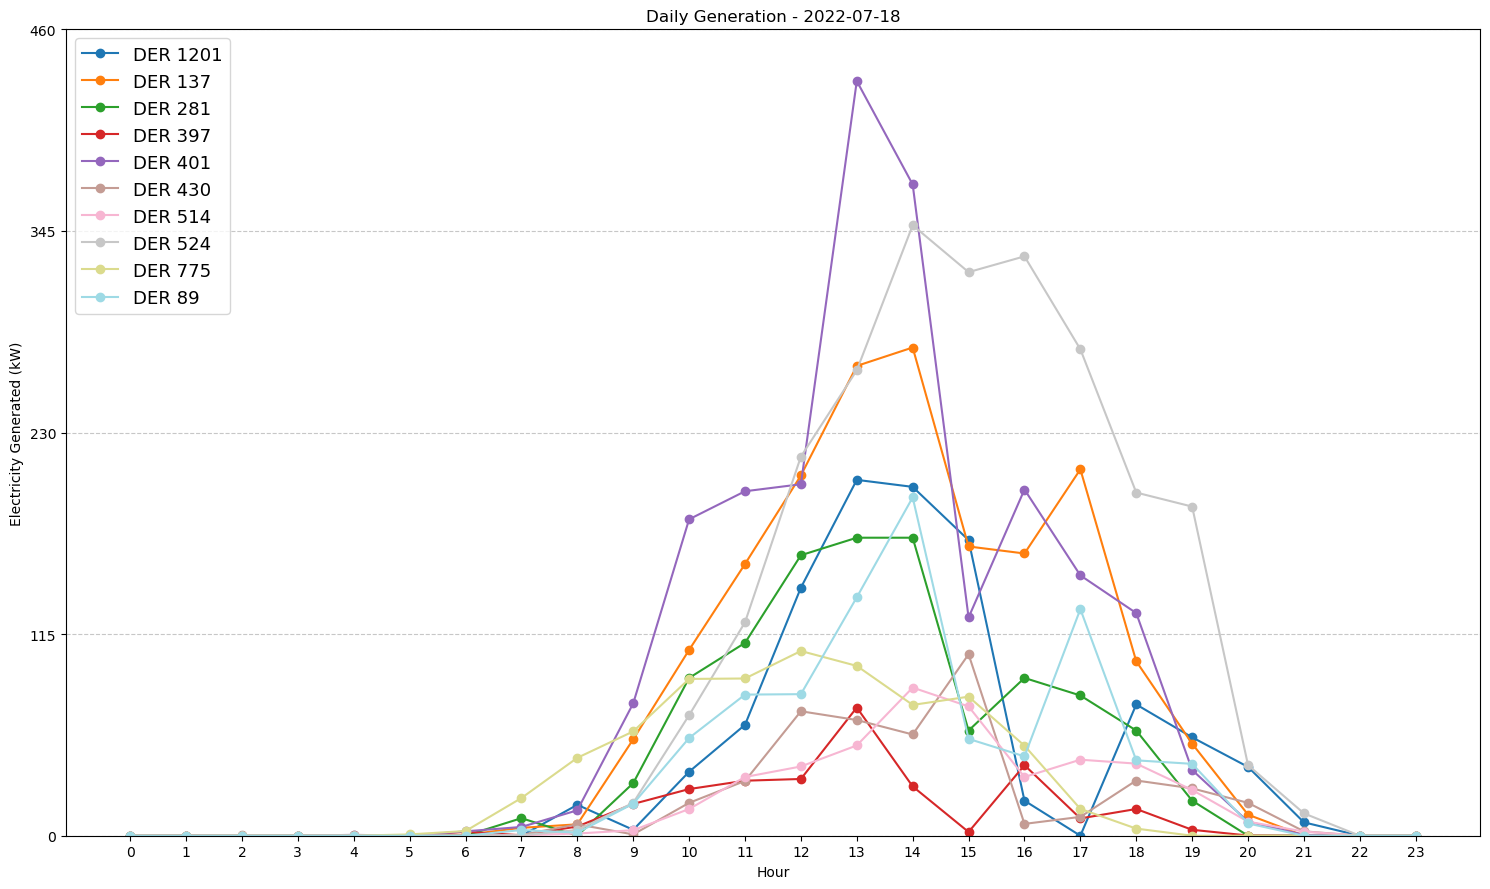

In [65]:
exclude_files = ['106.csv', '228.csv', '236.csv', '248.csv','261.csv', '525.csv', '583.csv', '673.csv', '692.csv', '745.csv', '765.csv', '689.csv', '1113.csv', '1341.csv']
data = load_generation_data(exclude_files)
plot_daily_generation(data, 18)

### price analysis

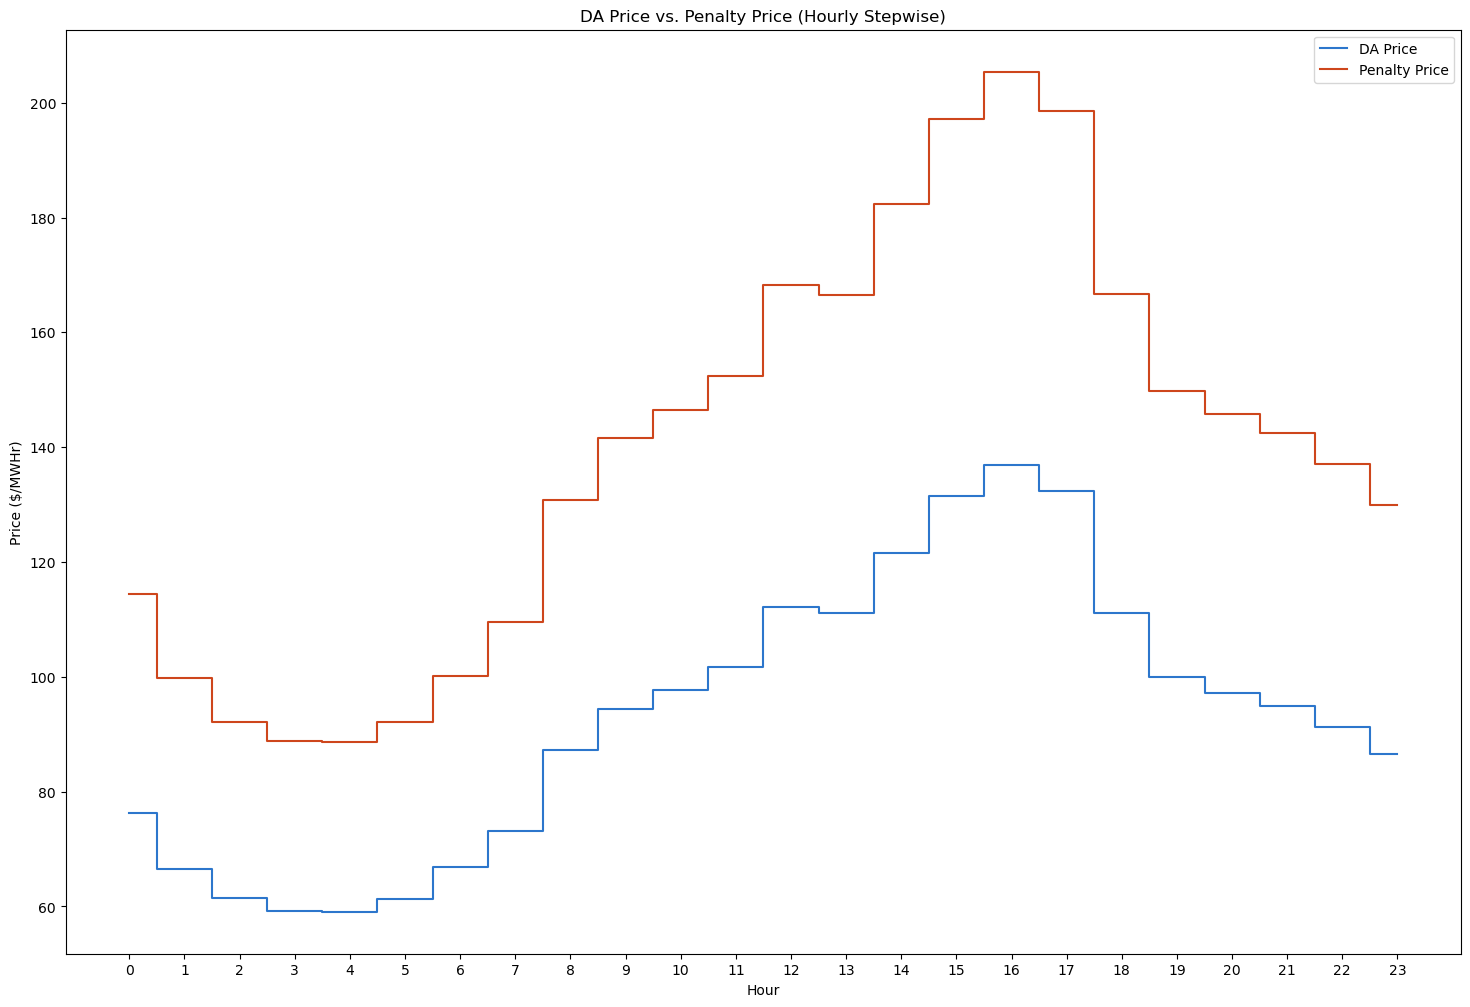

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV 파일 로드
file_path = "/Users/jangseohyun/Documents/workspace/symply/DER/data/price/20220718da.csv"
ny_da = pd.read_csv(file_path)

# 'Time Stamp'을 datetime 형식으로 변환
ny_da["Time Stamp"] = pd.to_datetime(ny_da["Time Stamp"])

# 시간(Hour)만 추출하여 새로운 컬럼 생성
ny_da["Hour"] = ny_da["Time Stamp"].dt.hour

# N.Y.C. 데이터 필터링
nyc_data = ny_da[ny_da["Name"] == "N.Y.C."]

# DA 가격과 Penalty 가격 계산
da = nyc_data["LBMP ($/MWHr)"].to_numpy()
pen = da * 1.5
hours = nyc_data["Hour"].to_numpy()

# 그래프 그리기
plt.figure(figsize=(18, 12))
plt.step(hours, da, label="DA Price", where='mid', linestyle='-', color="#2c76cc")
plt.step(hours, pen, label="Penalty Price", where='mid', linestyle='-', color="#ce461c")

# 그래프 꾸미기
plt.xlabel("Hour")
plt.ylabel("Price ($/MWHr)")
plt.title("DA Price vs. Penalty Price (Hourly Stepwise)")
plt.xticks(np.arange(0, 24, 1))  # 0~23시간 설정
plt.legend()
# plt.grid(True)

# 그래프 출력
plt.show()


C:\Users\jangseohyun\AppData\Local\Temp\ipykernel_17808\3934732449.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")  # 시간을 기준으로 그룹화


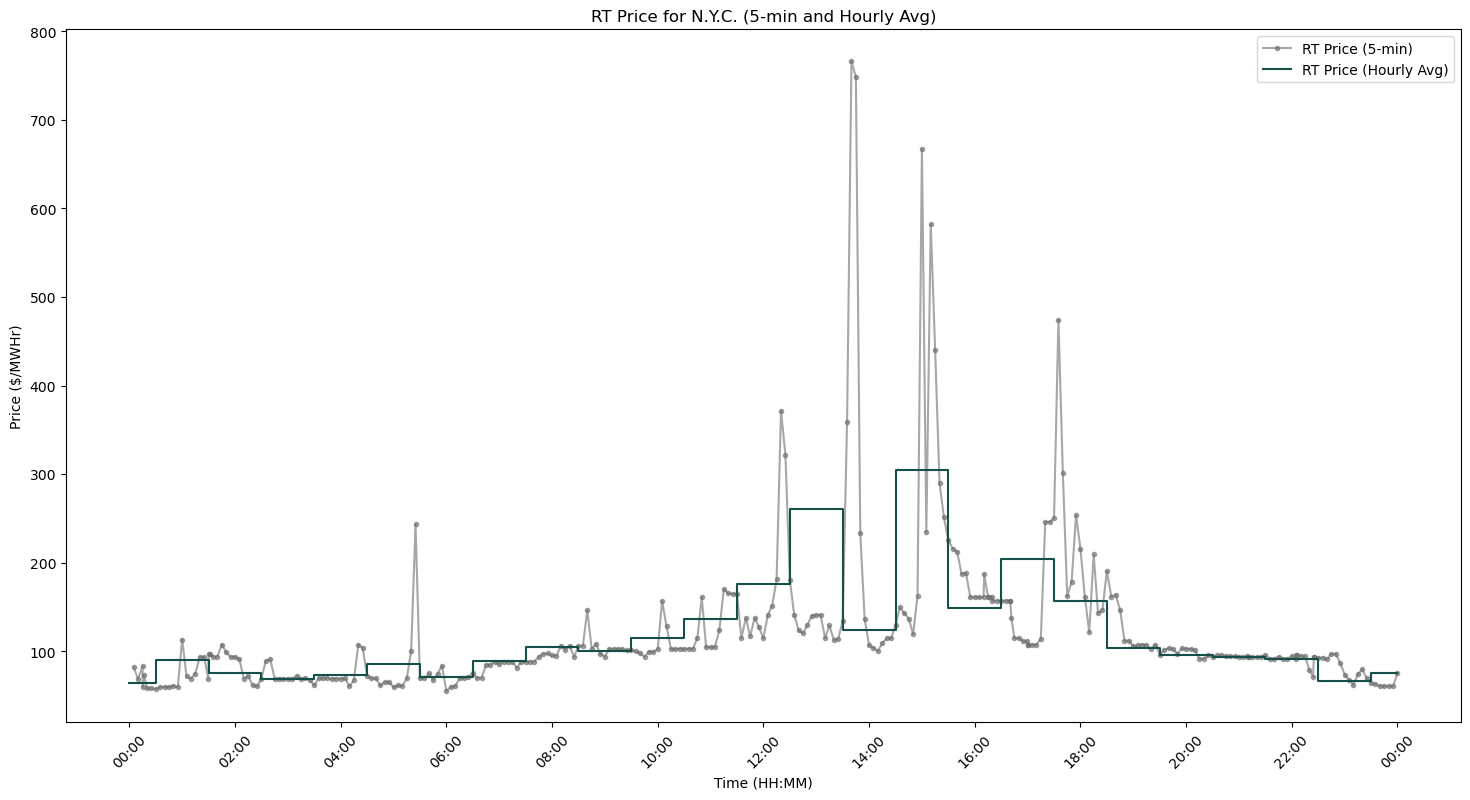

In [67]:
# CSV 파일 로드
file_path = r"C:\Users\jangseohyun\Documents\workspace\symply\DER\data\price\20220718rt.csv"
rt_da = pd.read_csv(file_path)

# 날짜 데이터 변환
rt_da["Time Stamp"] = pd.to_datetime(rt_da["Time Stamp"])

# NYC 데이터 필터링
nyc_rt = rt_da[rt_da["Name"] == "N.Y.C."]

# 5분 단위 가격
time_5min = nyc_rt["Time Stamp"]
price_5min = nyc_rt["LBMP ($/MWHr)"].to_numpy()

# 1시간 단위 평균 가격 계산
nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")  # 시간을 기준으로 그룹화
hourly_avg = nyc_rt.groupby("Hour")["LBMP ($/MWHr)"].mean().reset_index()
time_hourly = hourly_avg["Hour"]
price_hourly = hourly_avg["LBMP ($/MWHr)"].to_numpy()

# 플롯 그리기
plt.figure(figsize=(18, 9))

# 5분별 가격 (점선 그래프)
plt.plot(time_5min, price_5min, label="RT Price (5-min)", linestyle='-', marker='o', markersize=3, alpha=0.6, color="#6c6c6c")

# 1시간 평균 가격 (계단형 그래프)
plt.step(time_hourly, price_hourly, label="RT Price (Hourly Avg)", linestyle='-', linewidth=1.5, color='#164f49', where='mid')

# 그래프 설정
plt.xticks(time_hourly[::2], time_hourly.dt.strftime('%H:%M')[::2], rotation=45)  # x축 라벨 포맷 변경
plt.xlabel("Time (HH:MM)")
plt.ylabel("Price ($/MWHr)")
plt.title("RT Price for N.Y.C. (5-min and Hourly Avg)")
plt.legend()

# 그래프 출력
plt.show()


C:\Users\jangseohyun\AppData\Local\Temp\ipykernel_17808\880062765.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")


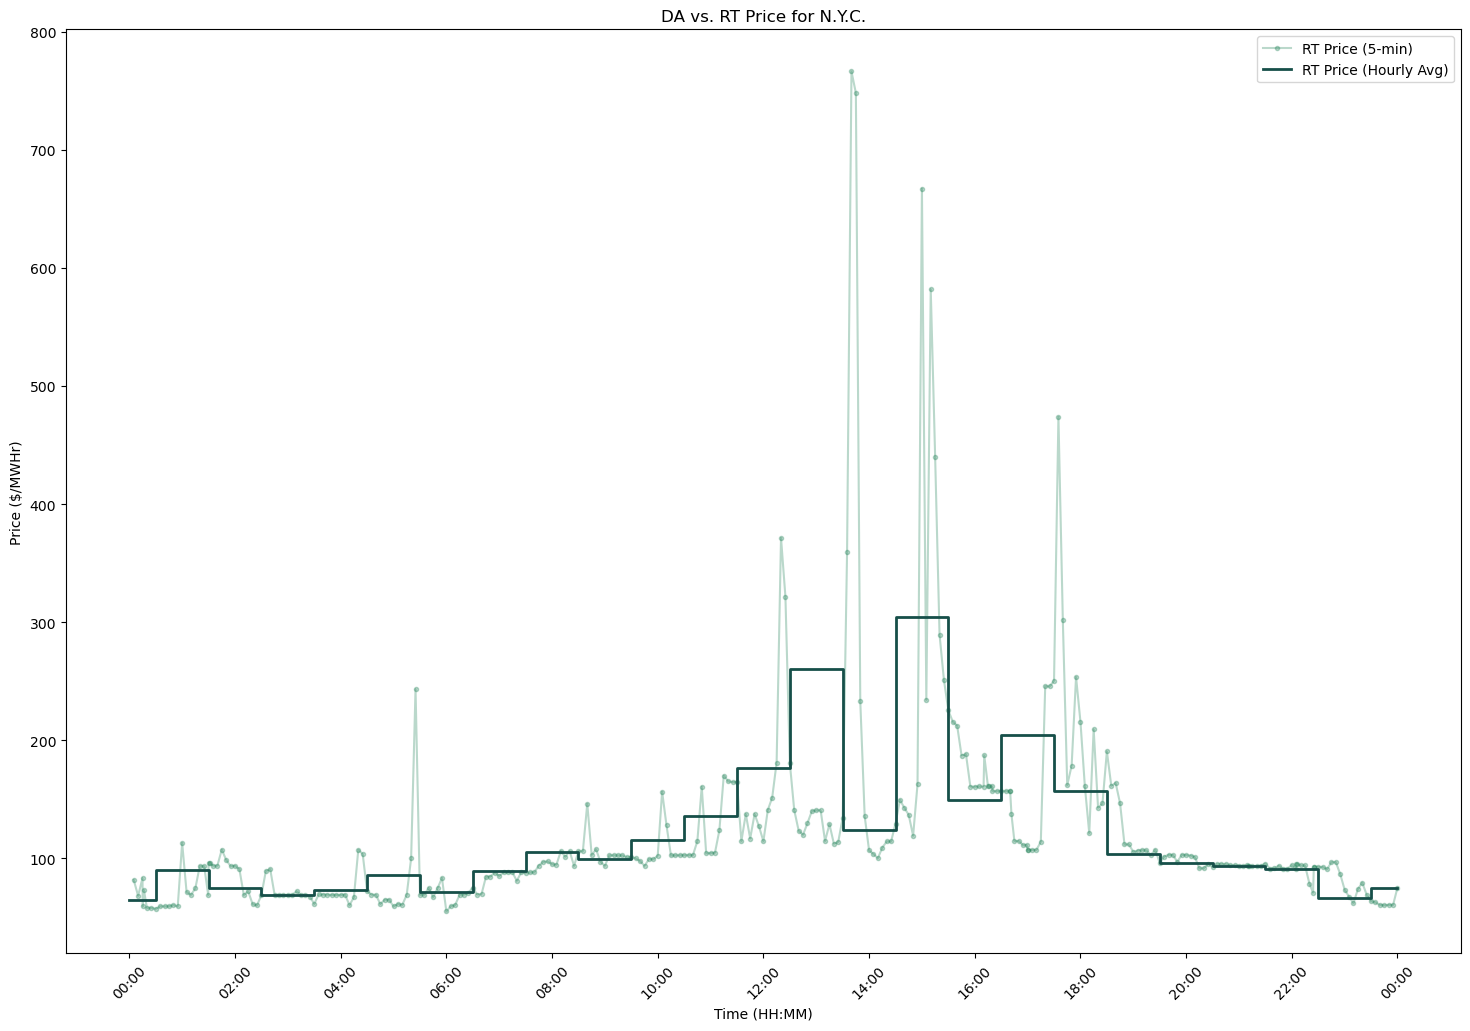

In [71]:
da_file_path = "/Users/jangseohyun/Documents/workspace/symply/DER/data/price/20220718da.csv"
rt_file_path = r"C:\Users\jangseohyun\Documents\workspace\symply\DER\data\price\20220718rt.csv"

ny_da = pd.read_csv(da_file_path)
ny_da["Time Stamp"] = pd.to_datetime(ny_da["Time Stamp"])
ny_da["Hour"] = ny_da["Time Stamp"].dt.hour
nyc_da = ny_da[ny_da["Name"] == "N.Y.C."]
da_price = nyc_da["LBMP ($/MWHr)"].to_numpy()
pen_price = da_price * 1.5
da_hours = nyc_da["Time Stamp"]

rt_da = pd.read_csv(rt_file_path)
rt_da["Time Stamp"] = pd.to_datetime(rt_da["Time Stamp"])
nyc_rt = rt_da[rt_da["Name"] == "N.Y.C."]
time_5min = nyc_rt["Time Stamp"]
price_5min = nyc_rt["LBMP ($/MWHr)"].to_numpy()

nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")
hourly_avg = nyc_rt.groupby("Hour")["LBMP ($/MWHr)"].mean().reset_index()
time_hourly = hourly_avg["Hour"]
price_hourly = hourly_avg["LBMP ($/MWHr)"].to_numpy()

plt.figure(figsize=(18, 12))

plt.plot(time_5min, price_5min, label="RT Price (5-min)", linestyle='-', marker='o', markersize=3, alpha=0.3, color="#1c7f54")

plt.step(time_hourly, price_hourly, label="RT Price (Hourly Avg)", linestyle='-', linewidth=2, color='#164f49', where='mid')


plt.xticks(time_hourly[::2], time_hourly.dt.strftime('%H:%M')[::2], rotation=45) 
plt.xlabel("Time (HH:MM)")
plt.ylabel("Price ($/MWHr)")
plt.title("DA vs. RT Price for N.Y.C.")
plt.legend()

plt.show()

C:\Users\jangseohyun\AppData\Local\Temp\ipykernel_17808\1071374987.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")


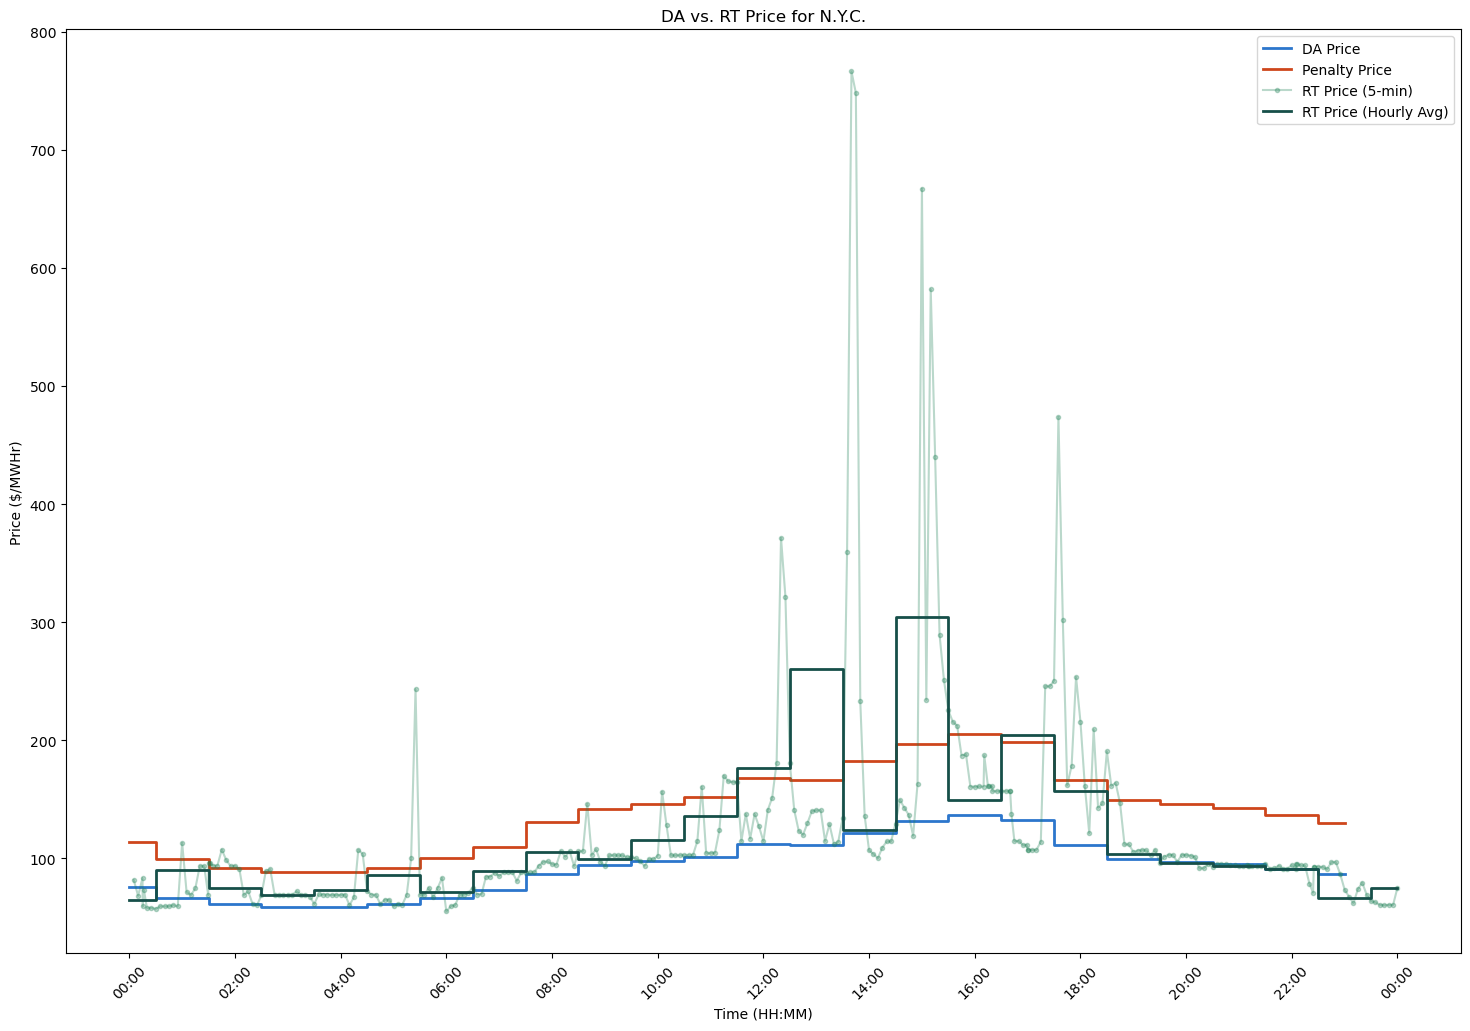

In [73]:
da_file_path = "/Users/jangseohyun/Documents/workspace/symply/DER/data/price/20220718da.csv"
rt_file_path = r"C:\Users\jangseohyun\Documents\workspace\symply\DER\data\price\20220718rt.csv"

ny_da = pd.read_csv(da_file_path)
ny_da["Time Stamp"] = pd.to_datetime(ny_da["Time Stamp"])
ny_da["Hour"] = ny_da["Time Stamp"].dt.hour
nyc_da = ny_da[ny_da["Name"] == "N.Y.C."]
da_price = nyc_da["LBMP ($/MWHr)"].to_numpy()
pen_price = da_price * 1.5
da_hours = nyc_da["Time Stamp"]

rt_da = pd.read_csv(rt_file_path)
rt_da["Time Stamp"] = pd.to_datetime(rt_da["Time Stamp"])
nyc_rt = rt_da[rt_da["Name"] == "N.Y.C."]
time_5min = nyc_rt["Time Stamp"]
price_5min = nyc_rt["LBMP ($/MWHr)"].to_numpy()

nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")
hourly_avg = nyc_rt.groupby("Hour")["LBMP ($/MWHr)"].mean().reset_index()
time_hourly = hourly_avg["Hour"]
price_hourly = hourly_avg["LBMP ($/MWHr)"].to_numpy()

plt.figure(figsize=(18, 12))


plt.step(da_hours, da_price, label="DA Price", where='mid', linestyle='-', color="#2c76cc", linewidth=2)
plt.step(da_hours, pen_price, label="Penalty Price", where='mid', linestyle='-', color="#ce461c", linewidth=2)

plt.plot(time_5min, price_5min, label="RT Price (5-min)", linestyle='-', marker='o', markersize=3, alpha=0.3, color="#1c7f54")

plt.step(time_hourly, price_hourly, label="RT Price (Hourly Avg)", linestyle='-', linewidth=2, color='#164f49', where='mid')

plt.xticks(time_hourly[::2], time_hourly.dt.strftime('%H:%M')[::2], rotation=45) 
plt.xlabel("Time (HH:MM)")
plt.ylabel("Price ($/MWHr)")
plt.title("DA vs. RT Price for N.Y.C.")
plt.legend()

plt.show()


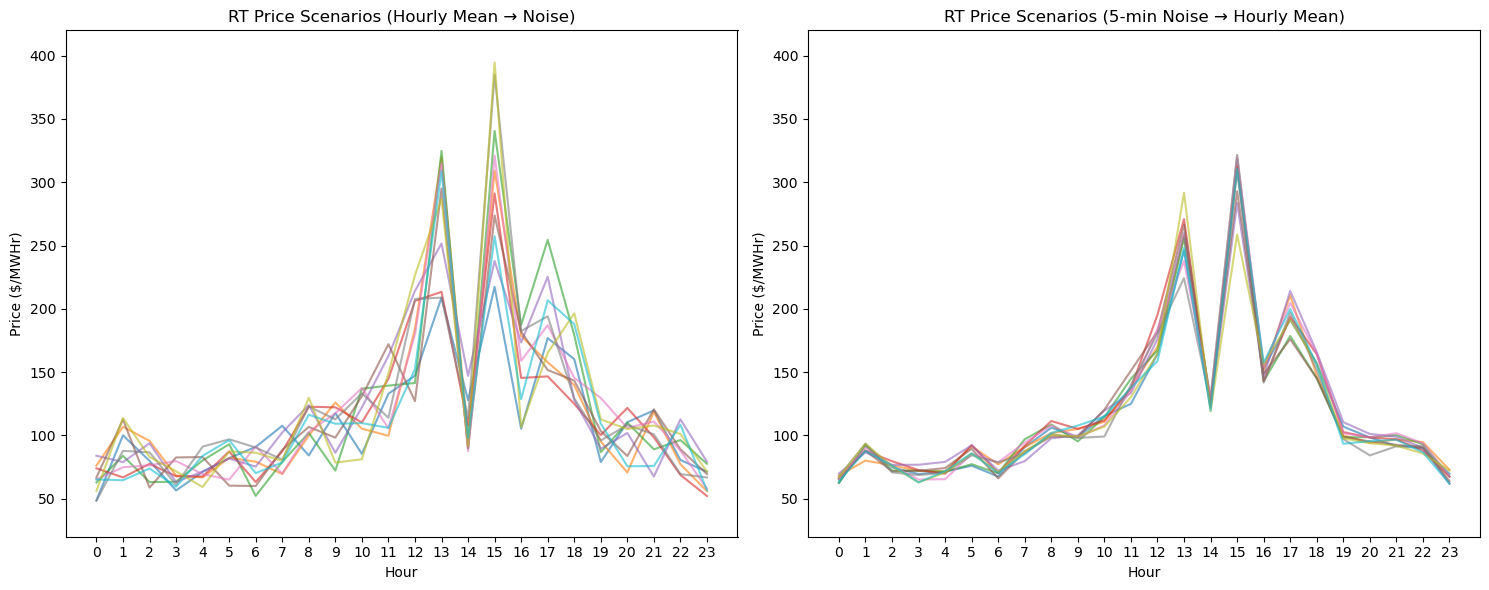

In [80]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

def generate_rt_scenarios(rt_price_data, time_stamps, S, randomness_level, method="hourly"):
    """
    실시간 가격 시나리오 생성

    Parameters:
    rt_price_data: np.array - 5분 간격 실시간 가격 데이터 (N.Y.C. 필터링됨)
    time_stamps: pd.Series - 5분 간격 타임스탬프 데이터
    S: int - 생성할 시나리오 수
    randomness_level: str - "low", "medium", "high" 중 하나
    method: str - "hourly" (한시간 평균 후 노이즈) 또는 "5min" (5분별 노이즈 후 평균)

    Returns:
    scenario_prices: np.array - shape (24, S) 시나리오 가격 데이터 (한 시간 간격)
    """

    np.random.seed(7)
    
    # 노이즈 범위 설정
    noise_ranges = {
        "low": (0.95, 1.05),
        "medium": (0.85, 1.15),
        "high": (0.7, 1.3),
    }
    
    if randomness_level not in noise_ranges:
        raise ValueError("Invalid randomness level. Please choose 'low', 'medium', or 'high'.")
    
    low, high = noise_ranges[randomness_level]

    # 시간 정보를 시간 단위로 변환
    time_stamps = pd.to_datetime(time_stamps)
    hourly_avg = pd.DataFrame({'Price': rt_price_data, 'Hour': time_stamps.dt.hour})

    if method == "hourly":
        # 방법 1: 한 시간 평균 구한 후 노이즈 적용
        hourly_prices = hourly_avg.groupby("Hour")["Price"].mean().to_numpy()
        noise_factors = np.random.uniform(low, high, size=(24, S))
        scenario_prices = np.expand_dims(hourly_prices, axis=-1) * noise_factors

    elif method == "5min":
        # 방법 2: 5분별 노이즈 적용 후 다시 평균
        hourly_price_list = []
        for hour in range(24):
            # 해당 시간(hour)에 해당하는 5분 간격 데이터 가져오기
            hourly_data = hourly_avg[hourly_avg["Hour"] == hour]["Price"].to_numpy()
            if len(hourly_data) == 0:
                hourly_price_list.append(np.zeros(S))  # 데이터 없는 시간은 0
                continue
            
            # 시나리오 개수만큼 노이즈 추가
            noise_factors = np.random.uniform(low, high, size=(len(hourly_data), S))
            noisy_data = np.expand_dims(hourly_data, axis=-1) * noise_factors  # (N, S) 형태
            hourly_scenario_prices = noisy_data.mean(axis=0)  # 시나리오별 평균 계산
            
            hourly_price_list.append(hourly_scenario_prices)
        
        scenario_prices = np.array(hourly_price_list)  # (24, S) 형태

    else:
        raise ValueError("Invalid method. Choose 'hourly' or '5min'.")

    return scenario_prices  # shape (24, S)

# CSV 데이터 불러오기
file_path = r"C:\Users\jangseohyun\Documents\workspace\symply\DER\data\price\20220718rt.csv"
rt_da = pd.read_csv(file_path)

# NYC 필터링 및 데이터 추출
rt_da["Time Stamp"] = pd.to_datetime(rt_da["Time Stamp"])
nyc_rt = rt_da[rt_da["Name"] == "N.Y.C."]
time_5min = nyc_rt["Time Stamp"]
price_5min = nyc_rt["LBMP ($/MWHr)"].to_numpy()

# 시나리오 생성
S = 10  # 시나리오 수
randomness_level = "high"  # 노이즈 수준 설정
scenario_prices_hourly = generate_rt_scenarios(price_5min, time_5min, S, randomness_level, method="hourly")
scenario_prices_5min = generate_rt_scenarios(price_5min, time_5min, S, randomness_level, method="5min")


def plot_rt_scenarios(scenario_prices_hourly, scenario_prices_5min):
    """
    실시간 가격 시나리오 비교 플롯

    Parameters:
    scenario_prices_hourly: np.array - (24, S) 형태, 한 시간 평균 후 노이즈 적용한 시나리오
    scenario_prices_5min: np.array - (24, S) 형태, 5분 단위 노이즈 적용 후 평균낸 시나리오
    """
    
    hours = np.arange(24)
    S = scenario_prices_hourly.shape[1]

    plt.figure(figsize=(15, 6))

    # Hourly Mean 후 Noise 적용한 시나리오
    plt.subplot(1, 2, 1)
    for s in range(S):
        plt.plot(hours, scenario_prices_hourly[:, s], alpha=0.6)
    plt.xlabel("Hour")
    plt.ylabel("Price ($/MWHr)")
    plt.title("RT Price Scenarios (Hourly Mean → Noise)")
    plt.xticks(hours)
    plt.ylim(20,420)

    # 5분 단위 Noise 적용 후 Hourly Mean 계산한 시나리오
    plt.subplot(1, 2, 2)
    for s in range(S):
        plt.plot(hours, scenario_prices_5min[:, s], alpha=0.6)
    plt.xlabel("Hour")
    plt.ylabel("Price ($/MWHr)")
    plt.title("RT Price Scenarios (5-min Noise → Hourly Mean)")
    plt.xticks(hours)
    plt.ylim(20,420)

    plt.tight_layout()
    plt.show()

# 두 가지 방법 비교 플롯
plot_rt_scenarios(scenario_prices_hourly, scenario_prices_5min)
